# $\text{Variational Monte Carlo}$
## $\text{Hydrogen Molecule (Symmetric)}$
- Name: Utkarsh Maurya
- Roll No.: PH21B012

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from tqdm import tqdm
import math
import pandas as pd

### $\text{Defining Functions}$

In [24]:
# Calculate distances
@njit(cache=True)
def distance(r1, r2, R, eps=0):
    Rp1 = np.array([0.0, 0.0, -R/2])
    Rp2 = np.array([0.0, 0.0, R/2])
    
    r1p1 = np.sqrt(np.sum((r1 - Rp1)**2)) + eps
    r1p2 = np.sqrt(np.sum((r1 - Rp2)**2)) + eps
    r2p1 = np.sqrt(np.sum((r2 - Rp1)**2)) + eps
    r2p2 = np.sqrt(np.sum((r2 - Rp2)**2)) + eps
    
    r12 = np.sqrt(np.sum((r1 - r2)**2)) + eps
    
    return r1p1, r1p2, r2p1, r2p2, r12

# Newton-Raphson for alpha
@njit(cache=True)
def solve_alpha_newton(R, initial_alpha=1.5, max_iter=100):
    alpha = initial_alpha
    if R < 1e-10:
        return 2.0  

    for i in range(max_iter):
        func = alpha - 1.0 - np.exp(-R/alpha)
        func_deriv = 1.0 - (R/alpha**2) * np.exp(-R/alpha)
        delta = func / func_deriv
        alpha -= delta
        if abs(delta) < 1e-7: 
            break
    
    return max(alpha, 0.1)


In [25]:
# Wavefunction
@njit(cache = True)
def psi_H2(r1, r2, R, a, b, symmetric=True):
    r1p1, r1p2, r2p1, r2p2, r12 = distance(r1, r2, R)
    
    phi_1A = np.exp(-a * r1p1)
    phi_1B = np.exp(-a * r1p2)
    phi_2A = np.exp(-a * r2p1)
    phi_2B = np.exp(-a * r2p2)
    
    if symmetric:
        psi1 = phi_1A + phi_1B
        psi2 = phi_2A + phi_2B
    else:
        psi1 = phi_1A - phi_1B
        psi2 = phi_2A - phi_2B
    
    u_r12 = r12 / (2 * (1 + b * r12))
    F12 = np.exp(u_r12)
    
    return psi1 * psi2 * F12

In [26]:
# Local energy calculation
@njit(cache=True)
def local_energy_H2(r1, r2, R, a, b, symmetric = True):
    eps = 1e-10
    
    Rp1 = np.array([0.0, 0.0, -R/2])
    Rp2 = np.array([0.0, 0.0, R/2])
    
    vec_r1p1 = r1 - Rp1
    vec_r1p2 = r1 - Rp2
    vec_r2p1 = r2 - Rp1
    vec_r2p2 = r2 - Rp2
    
    vec_r12 = r1 - r2
    
    r1p1, r1p2, r2p1, r2p2, r12 = distance(r1, r2, R, eps)
    
    r1p1_hat = vec_r1p1 / r1p1
    r1p2_hat = vec_r1p2 / r1p2
    r2p1_hat = vec_r2p1 / r2p1
    r2p2_hat = vec_r2p2 / r2p2
    r12_hat = vec_r12 / r12
    
    f1a = np.exp(-a * r1p1)
    f1b = np.exp(-a * r1p2)
    f2a = np.exp(-a * r2p1)
    f2b = np.exp(-a * r2p2)
    
    if symmetric:
        sign = 1
    else:
        sign = -1
        
    phi1 = f1a + sign * f1b + eps
    phi2 = f2a + sign * f2b + eps
    K1_num = (a**2 - 2*a/r1p1)*f1a + sign * (a**2 - 2*a/r1p2)*f1b
    K2_num = (a**2 - 2*a/r2p1)*f2a + sign * (a**2 - 2*a/r2p2)*f2b
    
    G1_num = -a*(r1p1_hat * f1a + sign * r1p2_hat * f1b)
    G2_num = -a*(r2p1_hat * f2a + sign * r2p2_hat * f2b)
    
    K1 = -1/2 * K1_num / phi1
    K2 = -1/2 * K2_num / phi2
    
    G1 = G1_num / phi1
    G2 = G2_num / phi2    
        
    r12_dot_G = np.sum(r12_hat * (G1 - G2))
    
    K_total = K1 + K2
    term_1 = -b/(1 + b*r12)**3 + 1/(4*(1 + b*r12)**4) + 1/(r12 * (1 + b*r12)**2)
    term_2 = -1/(2 * (1 + b*r12)**2) * r12_dot_G 
    V = -1.0/r1p1 - 1.0/r1p2 - 1.0/r2p1 - 1.0/r2p2 + 1.0/r12 + 1.0/(R+eps)
    
    local_energy = K_total - term_1 + term_2 + V
    return local_energy

In [27]:
# Monte Carlo
@njit(cache=True)
def monte_carlo_H2(r1, r2, R, a, b, N_thermal, N, step, symmetric=True):
    energy = 0.0
    energy2 = 0.0
    r12_sum = 0.0
    
    for _ in range(N_thermal):
        r1_new = r1 + step * (np.random.random(r1.shape) - 0.5)
        r2_new = r2 + step * (np.random.random(r2.shape) - 0.5)
        wave = psi_H2(r1, r2, R, a, b, symmetric)
        wave_new = psi_H2(r1_new, r2_new, R, a, b, symmetric)
        
        if np.random.random() < (wave_new/wave)**2:
            r1 = r1_new
            r2 = r2_new
    
    for _ in range(N):
        r1_new = r1 + step * (np.random.random(r1.shape) - 0.5)
        r2_new = r2 + step * (np.random.random(r2.shape) - 0.5)
        wave = psi_H2(r1, r2, R, a, b, symmetric)
        wave_new = psi_H2(r1_new, r2_new, R, a, b, symmetric)
        
        if np.random.random() < (wave_new/wave)**2:
            r1 = r1_new
            r2 = r2_new 
        
        dE = local_energy_H2(r1, r2, R, a, b, symmetric)
        _, _, _, _, dr12 = distance(r1, r2, R)
        energy += dE
        energy2 += dE**2
        r12_sum += dr12
        
    return energy, energy2, r12_sum

@njit(cache=True)
def VMC_H2(r1, r2, R, a, b, N_thermal, N, step, symmetric=True):
    energy, energy2, r12_sum = monte_carlo_H2(r1.copy(), r2.copy(), R, a, b, N_thermal, N, step, symmetric)
    
    energy_mean = energy / N
    energy_var = energy2 / N - energy_mean**2
    r12_mean = r12_sum / N

    return energy_mean, energy_var, r12_mean

### $\text{Data}$

In [28]:
def symmetric_part():
    beta_values = np.linspace(0.1, 0.5, 10) 
    R_values = np.linspace(0.25, 4, 16) 
    N_thermal = 10**4
    N = 10**5
    step = 0.5

    r1 = step * (np.random.random(3) - 0.5)
    r2 = step * (np.random.random(3) - 0.5)


    results = []
    
    for i in tqdm(range(len(R_values))):
        a = solve_alpha_newton(R_values[i])
        
        E_min = float('inf')
        beta_opt = None
        E_var_opt = None
        r12_opt = None
        
        for beta in beta_values:
            E, E_var, r12 = VMC_H2(r1, r2, R_values[i], a, beta, N_thermal, N, step, symmetric=True)
            if E < E_min:
                E_min = E
                beta_opt = beta
                E_var_opt = E_var
                r12_opt = r12
        results.append((R_values[i], E_min, r12_opt))
    
    combined_df = pd.DataFrame(results, columns=['R', 'E_min', 'r12_opt'])

    return combined_df

df_symmetric = symmetric_part()

100%|██████████| 16/16 [00:36<00:00,  2.28s/it]


In [29]:
R_list = df_symmetric['R']
E_list = df_symmetric['E_min']
r12_list = df_symmetric['r12_opt']
opt_R = R_list[np.argmin(E_list)]

df_symmetric

,R,E_min,r12_opt
0,0.25,1.253402,1.415474
1,0.50,-0.516610,1.623213
2,0.75,-0.963463,1.760033
3,1.00,-1.112476,1.847390
4,1.25,-1.156356,2.026917
5,1.50,-1.158313,2.128763
6,1.75,-1.146117,2.266078
7,2.00,-1.123603,2.554675
8,2.25,-1.098994,2.709248
9,2.50,-1.072276,3.096123


### $\text{Plot}$

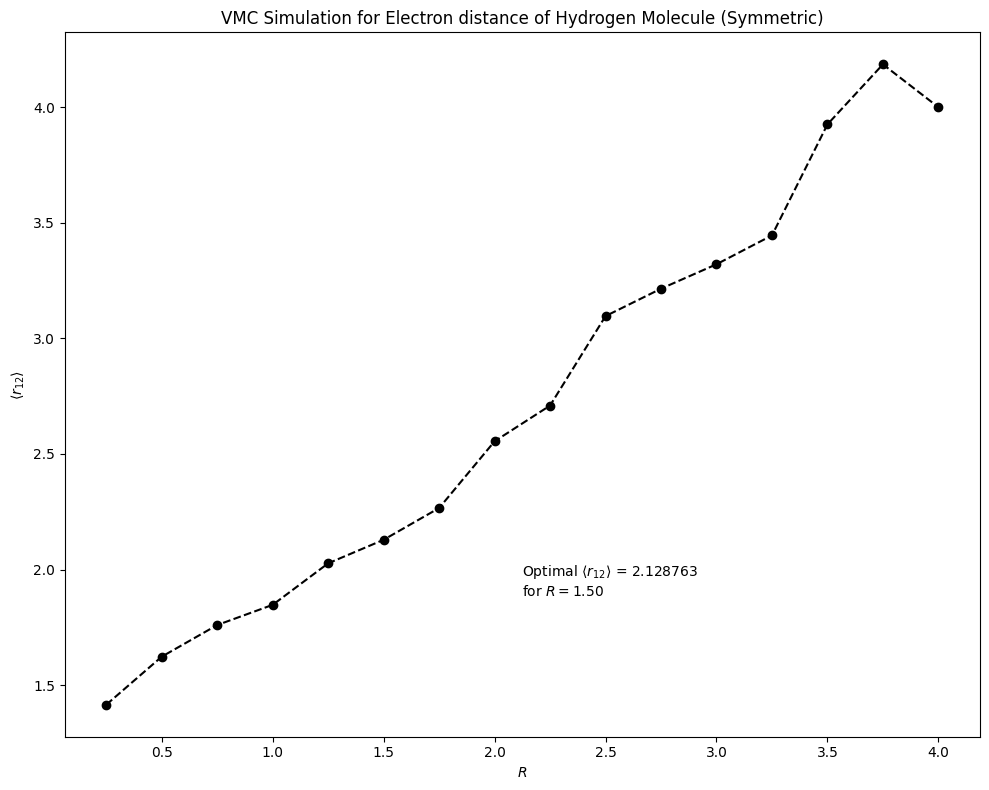

In [31]:
plt.figure(figsize=(10,8))
plt.plot(R_list, r12_list,'ko--')
plt.title('VMC Simulation for Electron distance of Hydrogen Molecule (Symmetric)')
plt.xlabel('$R$')
plt.ylabel('$\langle r_{12} \\rangle$')
plt.tight_layout()
plt.text(0.5,0.2,
         "Optimal $\langle r_{12} \\rangle$ = %f\nfor $R = %0.2f$"%(r12_list[np.argmin(E_list)], opt_R),
         transform=plt.gca().transAxes)
plt.show()